<a href="https://colab.research.google.com/github/fatemehes75/SpaceX-Falcon-9/blob/main/SpaceX_Falcon_9__Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **SpaceX Falcon 9 first stage Landing Prediction**

The goal of the project: determining if the Falcon 9 first stage will land successfully. SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. **Therefore if we can determine if the first stage will land, we can determine the cost of a launch.** This information can be used if an alternate company wants to bid against SpaceX for a rocket launch.

Table of content

1. Import libraries
2. Data wragling
3. Data alalysis
4. Exploratory analysis
5. Feature engineering
6. Predictive analysis
  * Logistic Regression
  * SVM
  * Decision Tree

## 1. Import libraries




In [1]:
import requests
import pandas as pd
import numpy as np
import datetime

1.1. loading data

In [ ]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
print(response.content)

In [3]:
json_result = response.json()
data = pd.json_normalize(json_result)

In [4]:
data.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,...,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],Ratsat was carried to orbit on the first succe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=dLQ2tZEH6G0,dLQ2tZEH6G0,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,NaN
4,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,True,[],None,[],[],...,None,None,[],[],http://www.spacex.com/press/2012/12/19/spacexs...,https://www.youtube.com/watch?v=yTaIDooc8Og,yTaIDooc8Og,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,NaN


**Functions** that will help us use the API to extract information using identification numbers in the launch data.

a function called **getBoosterVersion** that takes a dataframe data as input. loop: an API request for each entry in the 'rocket' column of the dataframe. The function aims to extract the booster versions of SpaceX rockets using the SpaceX API and append the information to a list called BoosterVersion

From the rocket column we would like to learn the booster name.

1.2. create functions

In [5]:
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the launchpad we would like to know the name of the launch site being used, the logitude, and the latitude.

In [6]:
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the payload we would like to learn the mass of the payload and the orbit that it is going to.

In [7]:
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From cores we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

In [8]:
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [9]:
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# we're interested in rockets with a single core and a single payload
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# We want to focus on launch data up to a specific date (November 13, 2020). So, we filter the dataset to keep only those rows where the launch date is on or before November 13, 2020.
data = data[data['date'] <= datetime.date(2020, 11, 13)]

<ipython-input-9-b25eccb7363d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cores'] = data['cores'].map(lambda x : x[0])
<ipython-input-9-b25eccb7363d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['payloads'] = data['payloads'].map(lambda x : x[0])
<ipython-input-9-b25eccb7363d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [10]:
data.head()

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight':...",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight':...",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight':...",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight':...",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight':...",6,2010-06-04T18:45:00.000Z,2010-06-04


1.3. create new df from original one

Now extracted information from the 'rocket', 'payload', 'launchpad', and 'cores' are stored in lists. These lists will be used to create a new dataframe.

In [11]:
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [12]:
BoosterVersion

[]

In [13]:
getBoosterVersion(data)
getLaunchSite(data)
getCoreData(data)
getPayloadData(data)

In [14]:
PayloadMass[0:5]

[20, None, 165, 200, None]

Constructing our dataset using the data we have obtained

In [15]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [16]:
for key, value in launch_dict.items():
    print(f"{key}: {len(value)}")

FlightNumber: 94
Date: 94
BoosterVersion: 94
PayloadMass: 94
Orbit: 94
LaunchSite: 94
Outcome: 94
Flights: 94
GridFins: 94
Reused: 94
Legs: 94
LandingPad: 94
Block: 94
ReusedCount: 94
Serial: 94
Longitude: 94
Latitude: 94


In [17]:
launch_df = pd.DataFrame(launch_dict)

In [18]:
launch_df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [19]:
launch_df.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude
count,94.000000,88.000000,94.000000,90.000000,94.000000,94.000000,94.000000
mean,54.202128,5919.165341,1.755319,3.500000,3.053191,-75.553302,28.581782
std,30.589048,4909.689575,1.197544,1.595288,4.153938,53.391880,4.639981
min,1.000000,20.000000,1.000000,1.000000,0.000000,-120.610829,9.047721
25%,28.250000,2406.250000,1.000000,2.000000,0.000000,-80.603956,28.561857
50%,52.500000,4414.000000,1.000000,4.000000,1.000000,-80.577366,28.561857
75%,81.500000,9543.750000,2.000000,5.000000,4.000000,-80.577366,28.608058
max,106.000000,15600.000000,6.000000,5.000000,13.000000,167.743129,34.632093


Filter the dataframe to only include Falcon 9 launches

In [20]:
data_falcon9 = launch_df[launch_df['BoosterVersion'] == 'Falcon 9']
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


We have removed some values we should reset the FlgihtNumber column

In [21]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9.head()

<ipython-input-21-702a636afdf9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


## 2. Data Wrangling

In [22]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

 Dealing with missing values, replacing them with mean of column


In [23]:
payload_mass_mean = data_falcon9['PayloadMass'].mean()
data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, payload_mass_mean)

<ipython-input-23-14c2f5ac439f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['PayloadMass'] = data_falcon9['PayloadMass'].replace(np.nan, payload_mass_mean)


In [24]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [25]:
data_falcon9.to_csv('dataset_part_1.csv', index=False)

## 3. Data Analysis

In [26]:
df=pd.read_csv('dataset_part_1.csv')
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857


In [27]:
df.isnull().sum()/df.shape[0]*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        28.888889
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

In [28]:
df.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

The data contains several Space X launch facilities: Cape Canaveral Space Launch Complex 40 VAFB SLC 4E , Vandenberg Air Force Base Space Launch Complex 4E (SLC-4E), Kennedy Space Center Launch Complex 39A KSC LC 39A .The location of each Launch Is placed in the column LaunchSite

In [29]:
launch_site_counts = df['LaunchSite'].value_counts()
launch_site_counts

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

Each launch aims to an dedicated orbit, and here are some common orbit types:

*   <b>LEO</b>: Low Earth orbit (LEO)is an Earth-centred orbit with an altitude of 2,000 km (1,200 mi) or less (approximately one-third of the radius of Earth),\[1] or with at least 11.25 periods per day (an orbital period of 128 minutes or less) and an eccentricity less than 0.25.\[2] Most of the manmade objects in outer space are in LEO <a href='https://en.wikipedia.org/wiki/Low_Earth_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01'>\[1]</a>.

*   <b>VLEO</b>: Very Low Earth Orbits (VLEO) can be defined as the orbits with a mean altitude below 450 km. Operating in these orbits can provide a number of benefits to Earth observation spacecraft as the spacecraft operates closer to the observation<a href='https://www.researchgate.net/publication/271499606_Very_Low_Earth_Orbit_mission_concepts_for_Earth_Observation_Benefits_and_challenges?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01'>\[2]</a>.

*   <b>GTO</b> A geosynchronous orbit is a high Earth orbit that allows satellites to match Earth's rotation. Located at 22,236 miles (35,786 kilometers) above Earth's equator, this position is a valuable spot for monitoring weather, communications and surveillance. Because the satellite orbits at the same speed that the Earth is turning, the satellite seems to stay in place over a single longitude, though it may drift north to south,” NASA wrote on its Earth Observatory website <a  href="https://www.space.com/29222-geosynchronous-orbit.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" >\[3] </a>.

*   <b>SSO (or SO)</b>: It is a Sun-synchronous orbit  also called a heliosynchronous orbit is a nearly polar orbit around a planet, in which the satellite passes over any given point of the planet's surface at the same local mean solar time <a href="https://en.wikipedia.org/wiki/Sun-synchronous_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">\[4] <a>.

*   <b>ES-L1 </b>:At the Lagrange points the gravitational forces of the two large bodies cancel out in such a way that a small object placed in orbit there is in equilibrium relative to the center of mass of the large bodies. L1 is one such point between the sun and the earth <a href="https://en.wikipedia.org/wiki/Lagrange_point?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01#L1_point">\[5]</a> .

*   <b>HEO</b> A highly elliptical orbit, is an elliptic orbit with high eccentricity, usually referring to one around Earth <a href="https://en.wikipedia.org/wiki/Highly_elliptical_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">\[6]</a>.

*   <b> ISS </b> A modular space station (habitable artificial satellite) in low Earth orbit. It is a multinational collaborative project between five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada)<a href="https://en.wikipedia.org/wiki/International_Space_Station?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01"> \[7] </a>

*   <b> MEO </b> Geocentric orbits ranging in altitude from 2,000 km (1,200 mi) to just below geosynchronous orbit at 35,786 kilometers (22,236 mi). Also known as an intermediate circular orbit. These are "most commonly at 20,200 kilometers (12,600 mi), or 20,650 kilometers (12,830 mi), with an orbital period of 12 hours <a href="https://en.wikipedia.org/wiki/List_of_orbits?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01"> \[8] </a>

*   <b> HEO </b> Geocentric orbits above the altitude of geosynchronous orbit (35,786 km or 22,236 mi) <a href="https://en.wikipedia.org/wiki/List_of_orbits?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01"> \[9] </a>

*   <b> GEO </b> It is a circular geosynchronous orbit 35,786 kilometres (22,236 miles) above Earth's equator and following the direction of Earth's rotation <a href="https://en.wikipedia.org/wiki/Geostationary_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01"> \[10] </a>

*   <b> PO </b> It is one type of satellites in which a satellite passes above or nearly above both poles of the body being orbited (usually a planet such as the Earth <a href="https://en.wikipedia.org/wiki/Polar_orbit?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01"> \[11] </a>

some are shown in the following plot:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/Orbits.png)

In [30]:
orbit_counts = df['Orbit'].value_counts()
orbit_counts

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

The number and occurence of mission outcome per orbit type

In [31]:
landing_outcomes = df['Outcome'].value_counts()
landing_outcomes

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

**True Ocean** means the mission outcome was successfully landed to a specific region of the ocean while **False Ocean** means the mission outcome was unsuccessfully landed to a specific region of the ocean. **True RTLS** means the mission outcome was successfully landed to a ground pad **False RTLS** means the mission outcome was unsuccessfully landed to a ground pad.**True ASDS** means the mission outcome was successfully landed to a drone ship False ASDS means the mission outcome was unsuccessfully landed to a drone ship. **None ASDS** and None None these represent a failure to land.

In [32]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [33]:
#set of outcomes where the second stage did not land successfully
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [34]:
landing_class = [0 if outcome in bad_outcomes else 1 for outcome in df['Outcome']]
print(landing_class)

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [35]:
df['Class']=landing_class
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [36]:
df["Class"].mean() #success rate

0.6666666666666666

In [37]:
df.to_csv("dataset_part_2.csv", index=False)

## 4. Exploratory Analysis

In [38]:
df=pd.read_csv('dataset_part_2.csv')
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

### How the FlightNumber (indicating the continuous launch attempts.) and Payload variables would affect the launch outcome.

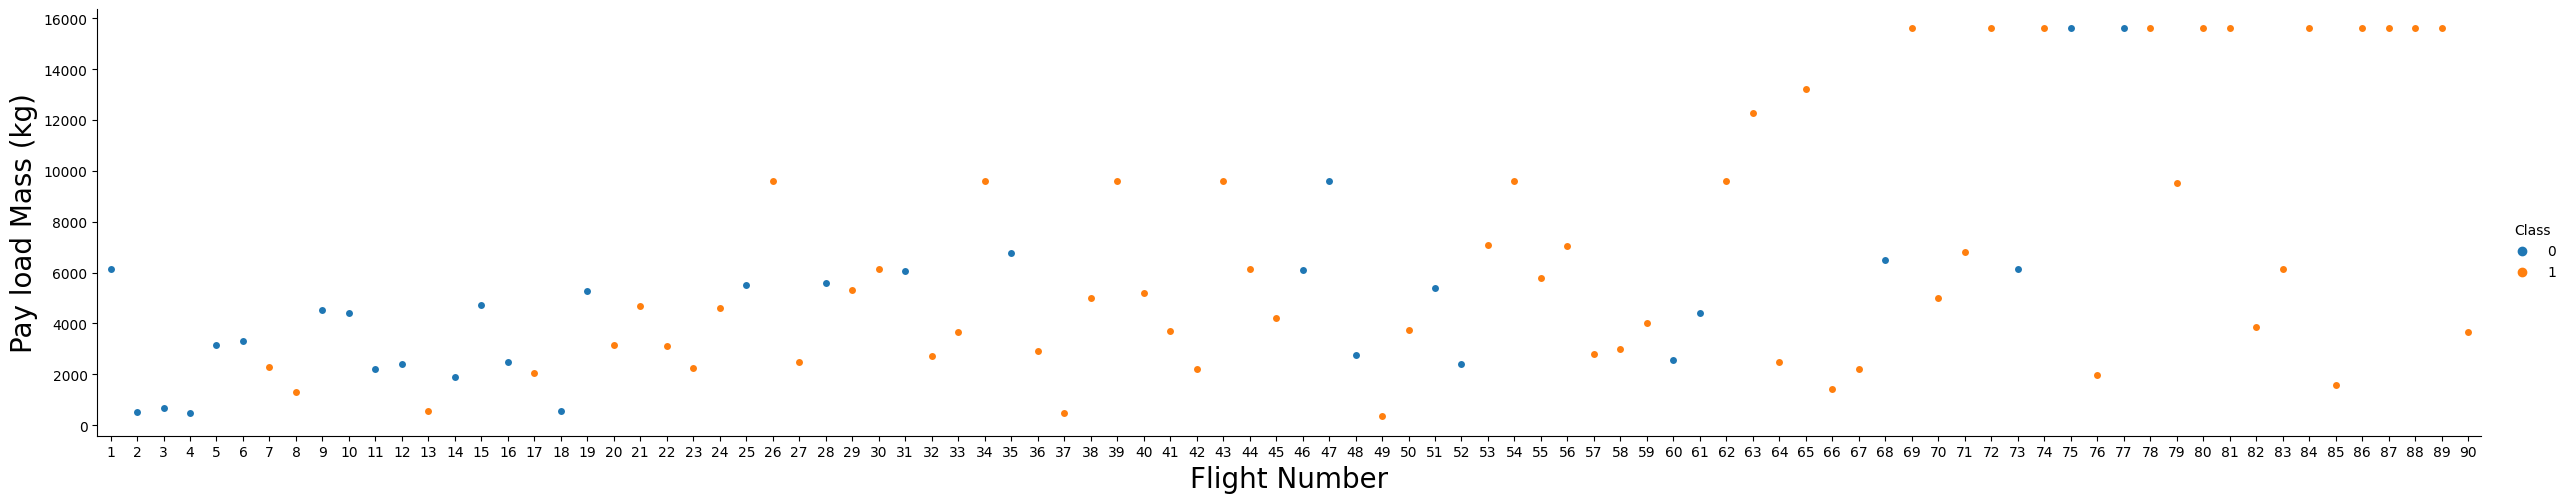

In [40]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

We see that different launch sites have different success rates. CCAFS LC-40, has a success rate of 60 %, while KSC LC-39A and VAFB SLC 4E has a success rate of 77%.

### The relationship between Flight Number and Launch Site


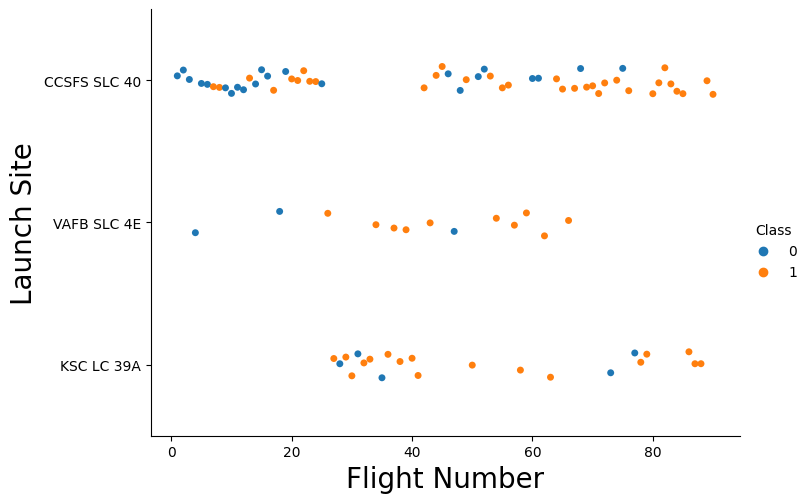

In [41]:
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=df, aspect = 1.5 ,height=5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

It can be concluded, as the flight number increases in 3 types of launch sites, so does the success rate. For instance, the success rate for the VAFB SLC 4E launch site is 100% after the Flight number 50. Both KSC LC 39A and CCAFS SLC 40 have a 100% success rates after 80th flight.

### The relationship between Payload and Launch Site

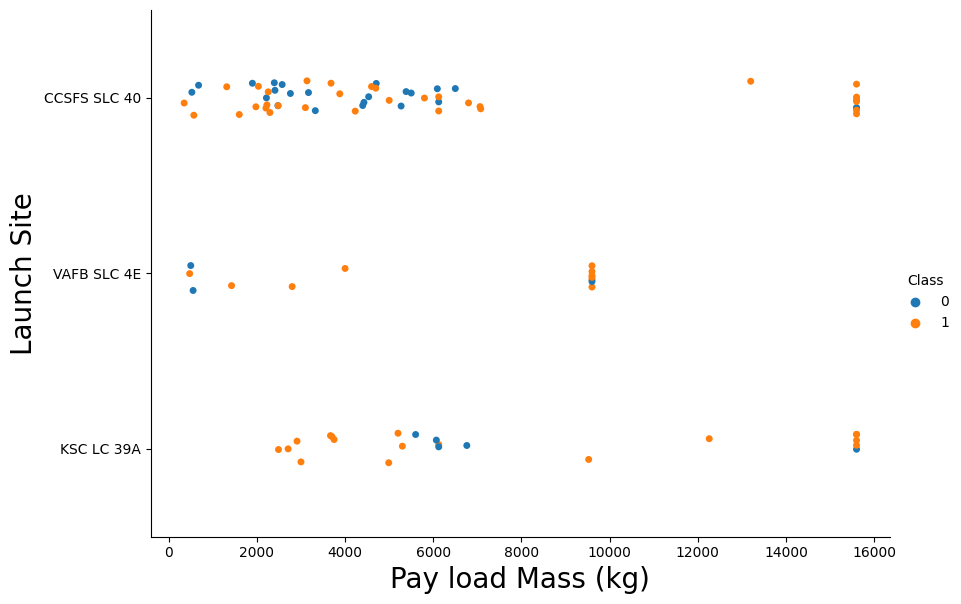

In [42]:
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=df, aspect = 1.5 ,height=6)
plt.xlabel("Pay load Mass (kg)",fontsize=20)
plt.ylabel("Launch Site",fontsize=20)
plt.show()

Now if you observe Payload Vs. Launch Site scatter point chart you will find for the VAFB-SLC launchsite there are no rockets launched for heavypayload mass(greater than 10000).

### The relationship between success rate of each orbit type

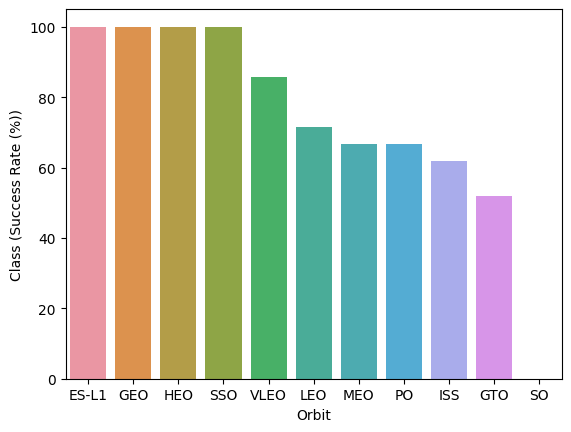

In [43]:
sr_df = df.groupby('Orbit')['Class'].mean().reset_index().sort_values(by='Class', ascending=False)
sr_df['Class'] = sr_df['Class'] * 100
sns.barplot(data=sr_df, x='Orbit', y='Class')
plt.xlabel('Orbit')
plt.ylabel('Class (Success Rate (%))')
plt.show()

Orbits ES-L1, GEO, HEO & SSO have the highest success rates at 100%, with SO orbit having the lowest success rate at ~50%. Orbit SO has 0% success rate.

### The relationship between FlightNumber and Orbit type

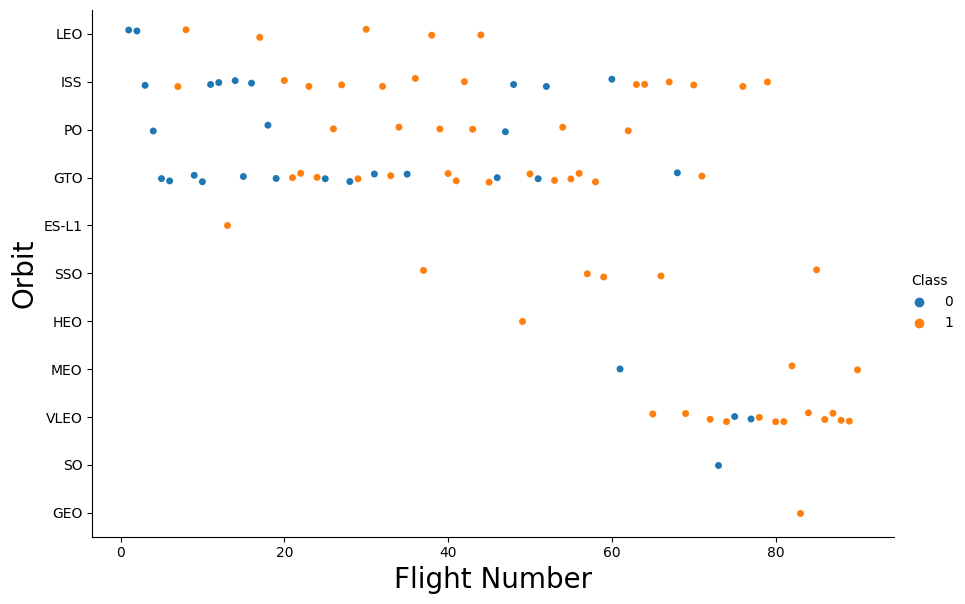

In [44]:
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=df, aspect = 1.5 ,height=6)

plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

You should see that in the LEO orbit the Success appears related to the number of flights; on the other hand, there seems to be no relationship between flight number when in GTO orbit.

### The relationship between Payload and Orbit type

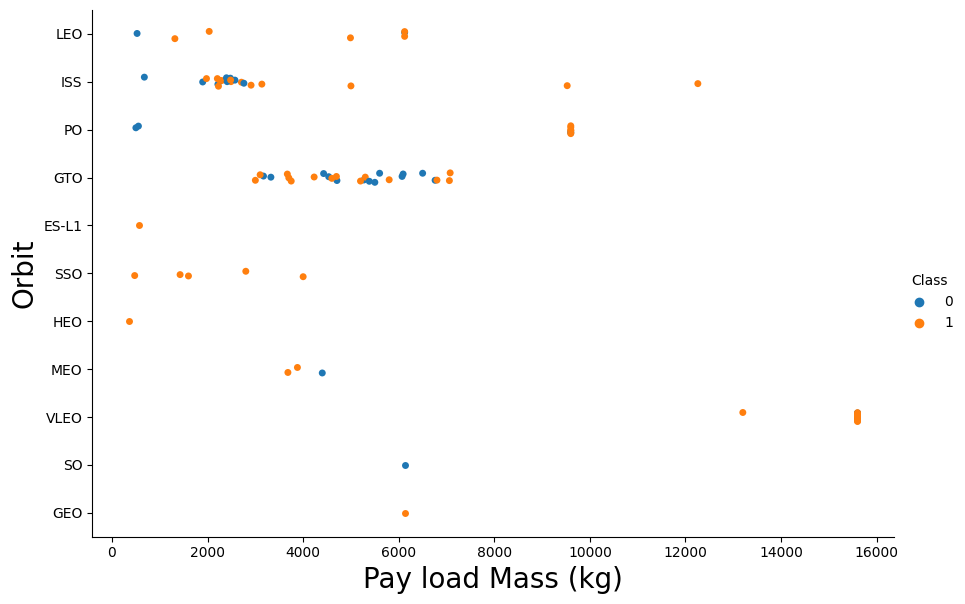

In [45]:
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=df, aspect = 1.5 ,height=6)
plt.xlabel("Pay load Mass (kg)",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

With heavy payloads the successful landing or positive landing rate are more for Polar,LEO and ISS.

However for GTO we cannot distinguish this well as both positive landing rate and negative landing(unsuccessful mission) are both there here.

### The launch success yearly trend

In [46]:
year=[]
def Extract_year():
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year
Extract_year()
df['Date'] = year
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


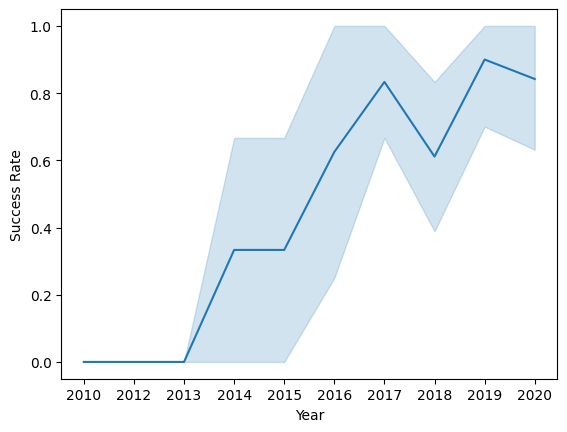

In [47]:
sns.lineplot(data=df, x="Date", y="Class")
plt.xlabel("Year")
plt.ylabel("Success Rate")
plt.show()

you can observe that the sucess rate since 2013 kept increasing till 2020

# 5. Feature engineering

In [48]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


5.1. Dummy variables to categorical columns

In [49]:
features_one_hot = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6123.547647,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,525.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,677.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,500.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,3170.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
features_one_hot.shape

(90, 80)

In [51]:
features_one_hot.astype('float64')

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15600.000000,2.0,1.0,1.0,1.0,5.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
86,87.0,15600.000000,3.0,1.0,1.0,1.0,5.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
87,88.0,15600.000000,6.0,1.0,1.0,1.0,5.0,12.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88,89.0,15600.000000,3.0,1.0,1.0,1.0,5.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [52]:
features_one_hot.to_csv('dataset_part_3.csv', index=False)

## 6. Predictive Analysis

In [53]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [54]:
data = pd.read_csv('dataset_part_2.csv')
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [55]:
data.columns

Index(['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs',
       'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude',
       'Class'],
      dtype='object')

In [56]:
X = pd.read_csv('dataset_part_3.csv')
X.head(100)

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1,6123.547647,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,525.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,677.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,500.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,3170.000000,1,False,False,False,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,15600.000000,2,True,True,True,5.0,12,0,0,...,0,0,0,0,0,0,0,0,1,0
86,87,15600.000000,3,True,True,True,5.0,13,0,0,...,0,0,0,0,0,0,1,0,0,0
87,88,15600.000000,6,True,True,True,5.0,12,0,0,...,0,0,0,1,0,0,0,0,0,0
88,89,15600.000000,3,True,True,True,5.0,12,0,0,...,0,0,0,0,0,0,0,0,1,0


In [57]:
Y = data['Class'].to_numpy() #Create a NumPy array from the column Class in data
Y.dtype

dtype('int64')

6.1. Normalization

In [58]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)
X

array([[-1.71291154,  0.        , -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-1.67441914, -1.18972425, -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [-1.63592675, -1.15742336, -0.65391284, ..., -0.21566555,
        -0.18569534, -0.10599979],
       ...,
       [ 1.63592675,  2.01380177,  3.49060516, ..., -0.21566555,
        -0.18569534, -0.10599979],
       [ 1.67441914,  2.01380177,  1.00389436, ..., -0.21566555,
         5.38516481, -0.10599979],
       [ 1.71291154, -0.51905572, -0.65391284, ..., -0.21566555,
        -0.18569534,  9.43398113]])

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=42)

Creating a GridSearchCV object logreg_cv with cv = 10. Fit the object to find the best parameters from the dictionary parameters

6.2. **Logistic Regression**

In [60]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [61]:
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [62]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8303571428571427


In [63]:
print("Logistic Regression test data accuracy :",logreg_cv.score(X_test, Y_test))

Logistic Regression test data accuracy : 0.9444444444444444


In [64]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

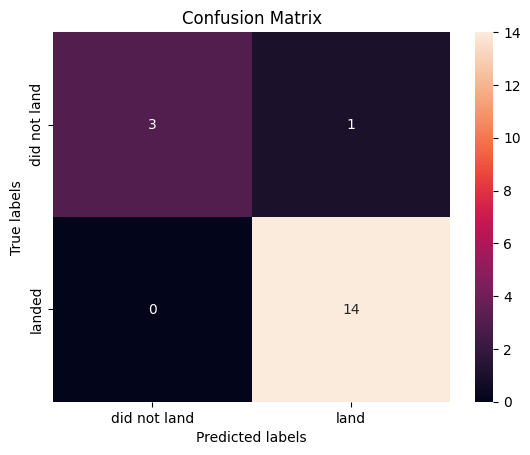

In [65]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
plt.show()

6.3. **SVM**

In [66]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv= 10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [67]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.03162277660168379, 'gamma': 0.001, 'kernel': 'linear'}
accuracy : 0.8321428571428571


In [68]:
print("SVM test data accuracy :",svm_cv.score(X_test, Y_test))

SVM test data accuracy : 0.8888888888888888


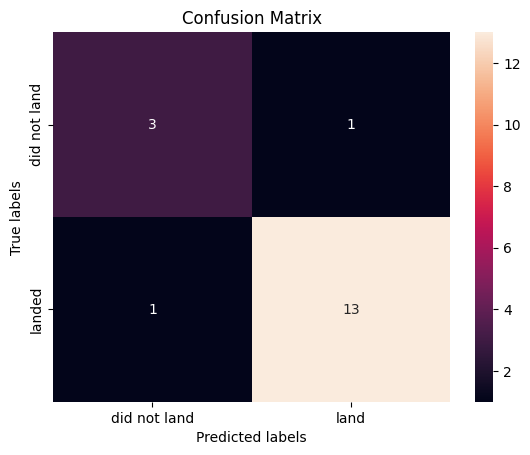

In [69]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
plt.show()

6.4. **Decision Tree**

In [70]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv= 10)
tree_cv.fit(X_train, Y_train)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_feat

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [71]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.8589285714285715


In [72]:
print("Decision Tree accuracy on test set :",tree_cv.score(X_test, Y_test))

Decision Tree accuracy on test set : 0.8888888888888888


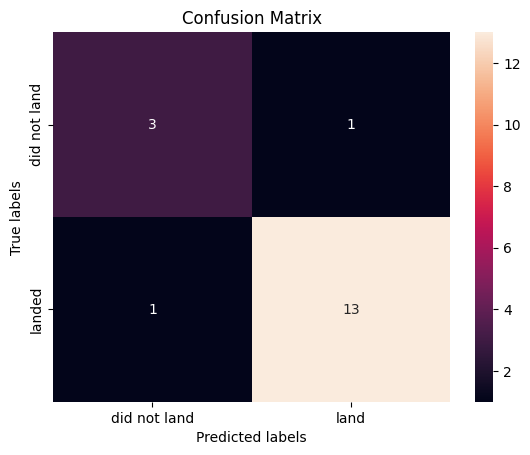

In [73]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
plt.show()

6.5. **KNN**

In [74]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}


KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, parameters, cv= 10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [75]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1}


In [76]:
knn_cv.score(X_test, Y_test)

0.8888888888888888

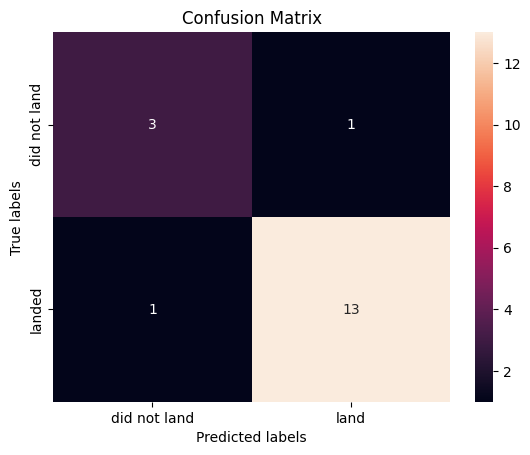

In [77]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
plt.show()

## **Find the method performs best:**

In [78]:
Report = pd.DataFrame({'Method' : ['Test Data Accuracy']})

knn_accuracy=knn_cv.score(X_test, Y_test)
Decision_tree_accuracy=tree_cv.score(X_test, Y_test)
SVM_accuracy=svm_cv.score(X_test, Y_test)
Logistic_Regression=logreg_cv.score(X_test, Y_test)

Report['Logistic_Reg'] = [Logistic_Regression]
Report['SVM'] = [SVM_accuracy]
Report['Decision Tree'] = [Decision_tree_accuracy]
Report['KNN'] = [knn_accuracy]




Report.transpose()

,0
Method,Test Data Accuracy
Logistic_Reg,0.944444
SVM,0.888889
Decision Tree,0.888889
KNN,0.888889
